# Лабораторная 3. Линейная регрессия



## Импорт необходимых библиотек


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Загрузка данных


In [3]:
df = pd.read_csv('Student_Performance.csv')

## 1. Визуализируем основные статистики по датасету


In [4]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


## Построение графиков для визуализации данных


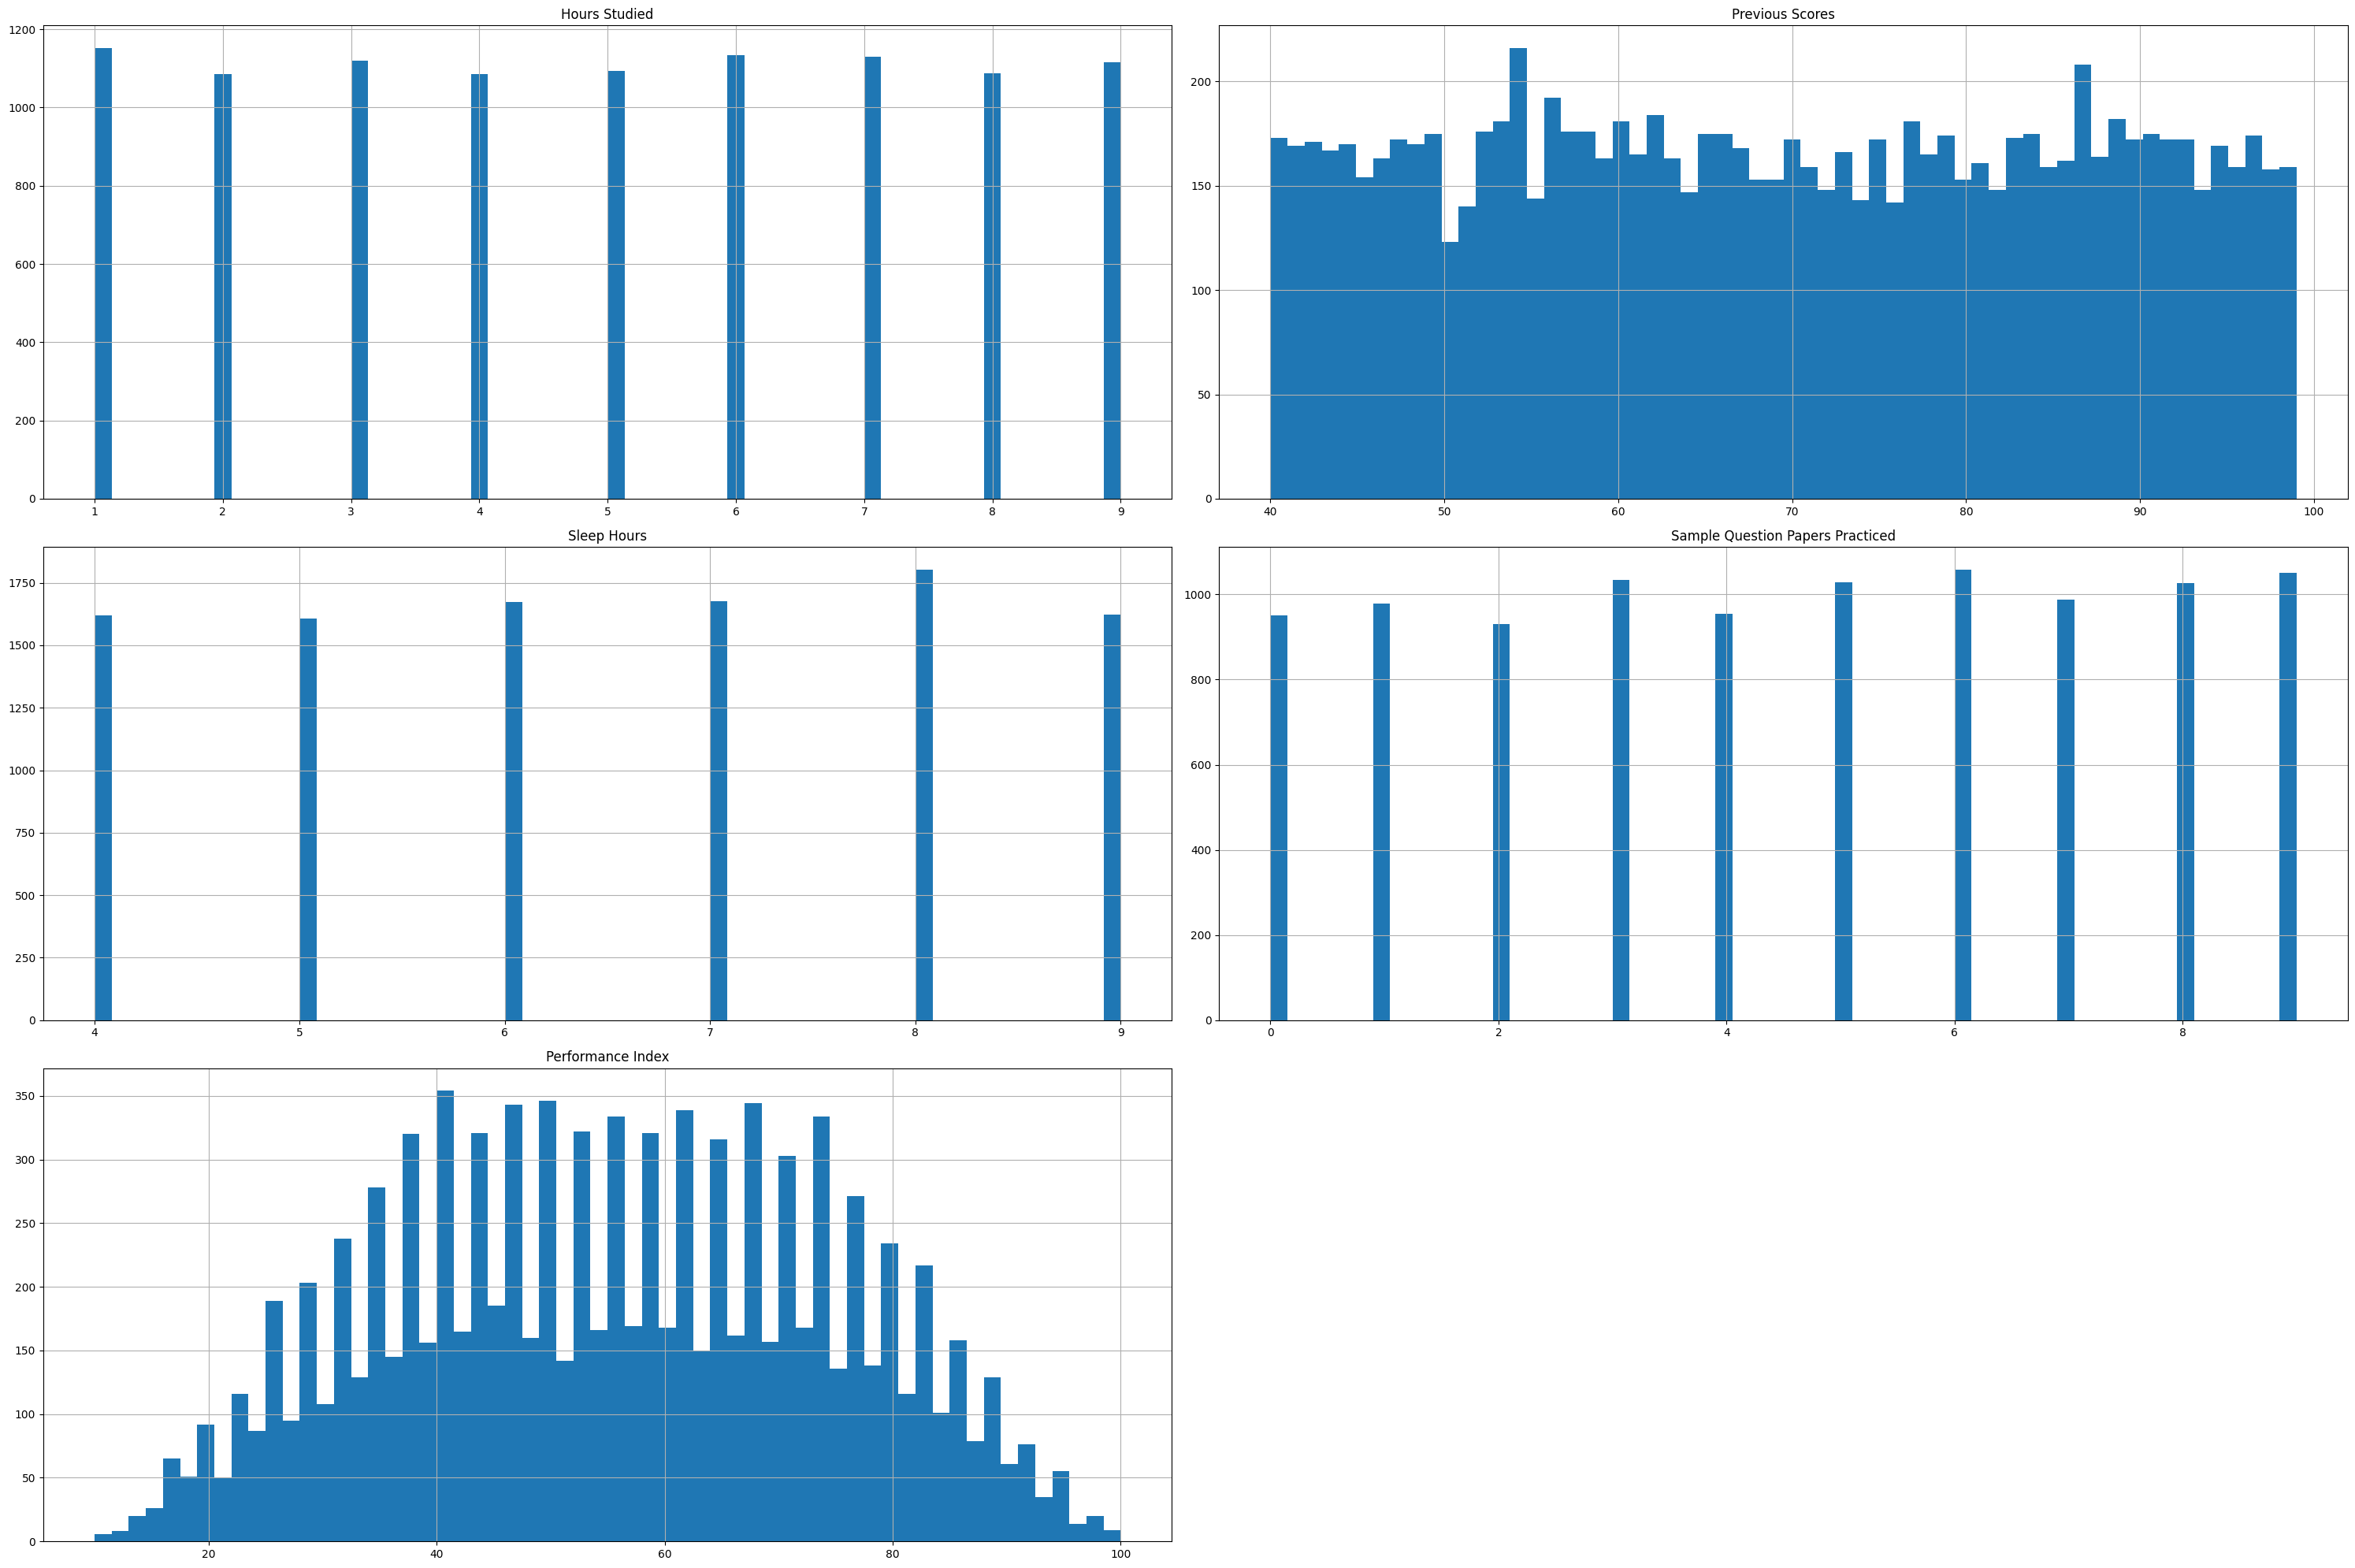

In [8]:
df.hist(bins=60, figsize=(30, 20))
plt.tight_layout()
plt.show()

## Корреляционная матрица для признаков


In [9]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
Hours Studied,1.000000,-0.012390,0.001245,0.017463,0.373730
Previous Scores,-0.012390,1.000000,0.005944,0.007888,0.915189
Sleep Hours,0.001245,0.005944,1.000000,0.003990,0.048106
Sample Question Papers Practiced,0.017463,0.007888,0.003990,1.000000,0.043268
Performance Index,0.373730,0.915189,0.048106,0.043268,1.000000


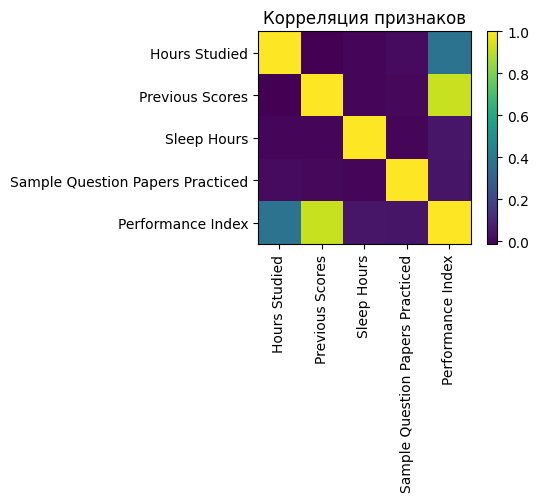

In [11]:
plt.figure(figsize=(6, 5))
plt.imshow(corr_matrix, cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Корреляция признаков")
plt.tight_layout()
plt.show()

## 2. Предварительная обработка данных

### Обработка пропущенных значений


In [12]:
df.isnull().sum()

,0
Hours Studied,0
Previous Scores,0
Extracurricular Activities,0
Sleep Hours,0
Sample Question Papers Practiced,0
Performance Index,0


### Заполняем пропущенные значения медианой


In [13]:
numeric_cols_all = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols_all:
    df[col] = df[col].fillna(df[col].median())

### Кодирование категориальных признаков

В нашем датасете есть категориальный признак `Extracurricular Activities` (Yes/No).
Преобразуем его в числовой с помощью one-hot encoding.


In [14]:
df_enc = pd.get_dummies(
    df,
    columns=['Extracurricular Activities'],
    drop_first=True
)

df_enc.head()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index,Extracurricular Activities_Yes
0,7,99,9,1,91.0,True
1,4,82,4,2,65.0,False
2,8,51,7,2,45.0,True
3,5,52,5,2,36.0,True
4,7,75,8,5,66.0,False


### Нормировка данных (Min-Max, своими руками)
Нормировку будем считать отдельно для обучающей выборки и применять к тестовой.


## 3. Разделение данных на обучающий и тестовый наборы


In [15]:
np.random.seed(42)

target_col = 'Performance Index'

n = len(df_enc)
indices = np.random.permutation(n)
train_size = int(0.8 * n)

train_idx = indices[:train_size]
test_idx = indices[train_size:]

train_df = df_enc.iloc[train_idx].reset_index(drop=True)
test_df = df_enc.iloc[test_idx].reset_index(drop=True)

print("Размер train:", train_df.shape)
print("Размер test:", test_df.shape)

Размер train: (8000, 6)
Размер test: (2000, 6)


In [16]:
# Разделяем на признаки и целевую переменную
X_train_raw = train_df.drop(columns=[target_col])
y_train = train_df[target_col].values

X_test_raw = test_df.drop(columns=[target_col])
y_test = test_df[target_col].values

### Нормировка (Min-Max) только по обучающей выборке


In [18]:
def minmax_fit(X_df: pd.DataFrame):
    X_num = X_df.astype(float)

    xmin = X_num.min()
    xmax = X_num.max()
    rng = (xmax - xmin).replace(0, 1)

    X_scaled = (X_num - xmin) / rng
    return X_scaled, xmin, rng

def minmax_transform(X_df: pd.DataFrame, xmin: pd.Series, rng: pd.Series):
    X_num = X_df.astype(float)
    return (X_num - xmin) / rng

X_train_scaled_df, xmin, xrng = minmax_fit(X_train_raw)
X_test_scaled_df = minmax_transform(X_test_raw, xmin, xrng)

X_train_scaled_df.head()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Extracurricular Activities_Yes
0,0.500,0.491525,0.8,0.222222,0.0
1,0.125,0.101695,0.0,0.888889,1.0
2,0.750,0.271186,0.6,0.555556,1.0
3,0.625,0.033898,0.8,0.555556,1.0
4,0.750,0.220339,0.0,0.666667,0.0


## 4. Реализация линейной регрессии без использования сторонних библиотек, кроме Pandas и NumPy


In [19]:
def add_intercept(X: np.ndarray):
    return np.c_[np.ones((X.shape[0], 1)), X]

def fit_linreg_normal_eq(X: np.ndarray, y: np.ndarray):
    # МНК через обратную матрицу
    XtX = X.T @ X
    XtX_inv = np.linalg.pinv(XtX)
    theta = XtX_inv @ X.T @ y
    return theta

def predict_linreg(X: np.ndarray, theta: np.ndarray):
    return X @ theta

def r2_score_manual(y_true: np.ndarray, y_pred: np.ndarray):
    # Коэффициент детерминации
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

def build_design_matrix(X_df: pd.DataFrame, feature_names):
    X_sub = X_df[feature_names].values
    return add_intercept(X_sub)

### Базовая модель: все признаки


In [20]:
all_features = list(X_train_scaled_df.columns)
print("Все признаки:", all_features)

# Матрицы признаков
X_train_with_intercept = add_intercept(X_train_scaled_df.values)
X_test_with_intercept = add_intercept(X_test_scaled_df.values)

# Оценка коэффициентов
theta = fit_linreg_normal_eq(X_train_with_intercept, y_train)

# Предсказания и коэф детерминации
y_pred = predict_linreg(X_test_with_intercept, theta)
r2 = r2_score_manual(y_test, y_pred)

print("Коэффициенты базовой модели (theta):")
print(theta)
print(f"Коэффициент детерминации R^2 (базовая модель, все признаки): {r2:.4f}")

Все признаки: ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 'Extracurricular Activities_Yes']
Коэффициенты базовой модели (theta):
[11.3923372  22.8103437  60.10071372  2.39248225  1.81281052  0.61508883]
Коэффициент детерминации R^2 (базовая модель, все признаки): 0.9888


## 5. Построение трёх моделей с различными наборами признаков


### Модель 1: использование всех признаков


In [21]:
features_model1 = all_features.copy()

X_train_1 = build_design_matrix(X_train_scaled_df, features_model1)
X_test_1 = build_design_matrix(X_test_scaled_df, features_model1)

theta_1 = fit_linreg_normal_eq(X_train_1, y_train)
y_pred_1 = predict_linreg(X_test_1, theta_1)
r2_1 = r2_score_manual(y_test, y_pred_1)

print(f"Модель 1 (все признаки), R^2 = {r2_1:.4f}")

Модель 1 (все признаки), R^2 = 0.9888


### Модель 2: использование наиболее коррелирующих признаков

По корреляционной матрице для `Performance Index` наибольшую корреляцию дают:
`Previous Scores`, `Hours Studied`, `Sample Question Papers Practiced`.


In [22]:
features_model2 = [
    "Previous Scores",
    "Hours Studied",
    "Sample Question Papers Practiced"
]

X_train_2 = build_design_matrix(X_train_scaled_df, features_model2)
X_test_2 = build_design_matrix(X_test_scaled_df, features_model2)

theta_2 = fit_linreg_normal_eq(X_train_2, y_train)
y_pred_2 = predict_linreg(X_test_2, theta_2)
r2_2 = r2_score_manual(y_test, y_pred_2)

print(f"Модель 2 (сильно коррелирующие признаки), R^2 = {r2_2:.4f}")

Модель 2 (сильно коррелирующие признаки), R^2 = 0.9867


### Модель 3: исключаем признак `Sleep Hours` и смотрим, как меняется качество


In [23]:
features_model3 = [f for f in all_features if f != "Sleep Hours"]

X_train_3 = build_design_matrix(X_train_scaled_df, features_model3)
X_test_3 = build_design_matrix(X_test_scaled_df, features_model3)

theta_3 = fit_linreg_normal_eq(X_train_3, y_train)
y_pred_3 = predict_linreg(X_test_3, theta_3)
r2_3 = r2_score_manual(y_test, y_pred_3)

print(f"Модель 3 (все признаки без Sleep Hours), R^2 = {r2_3:.4f}")

Модель 3 (все признаки без Sleep Hours), R^2 = 0.9870


## 6. Сравнение моделей


In [24]:
print("Сравнение моделей по R^2:")
print(f"Модель 1 (все признаки)                         R^2 = {r2_1:.4f}")
print(f"Модель 2 (коррелирующие признаки)                R^2 = {r2_2:.4f}")
print(f"Модель 3 (все признаки без Sleep Hours)          R^2 = {r2_3:.4f}")

Сравнение моделей по R^2:
Модель 1 (все признаки)                         R^2 = 0.9888
Модель 2 (коррелирующие признаки)                R^2 = 0.9867
Модель 3 (все признаки без Sleep Hours)          R^2 = 0.9870
